In [1]:
import numpy as np, pandas as pd
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [2]:
import sys
import os
os.environ["OMP_NUM_THREADS"] = "1"   # set before importing numpy/xgboost
os.environ["MKL_NUM_THREADS"] = "1"

classes_path = os.path.abspath(r"D:\Repositories\PhD\src\classes")
src_path = os.path.abspath(r"D:\Repositories\PhD\src\functions")
sys.path.append(src_path)
sys.path.append(classes_path)
print(sys.path)

import helpers
import cepstrum_fe

['d:\\Anaconda\\envs\\ml-cpu\\python311.zip', 'd:\\Anaconda\\envs\\ml-cpu\\DLLs', 'd:\\Anaconda\\envs\\ml-cpu\\Lib', 'd:\\Anaconda\\envs\\ml-cpu', '', 'd:\\Anaconda\\envs\\ml-cpu\\Lib\\site-packages', 'd:\\Anaconda\\envs\\ml-cpu\\Lib\\site-packages\\win32', 'd:\\Anaconda\\envs\\ml-cpu\\Lib\\site-packages\\win32\\lib', 'd:\\Anaconda\\envs\\ml-cpu\\Lib\\site-packages\\Pythonwin', 'D:\\Repositories\\PhD\\src\\functions', 'D:\\Repositories\\PhD\\src\\classes']


In [3]:
import importlib

In [4]:
importlib.reload(cepstrum_fe)

<module 'cepstrum_fe' from 'D:\\Repositories\\PhD\\src\\classes\\cepstrum_fe.py'>

In [5]:
def extract_features(signal, fs, label,
                     slice_len_s = 2, # slice length in seconds
                     hop_s = 0.25, #percentage overlap
                     frame_len_s=0.25, # Length of the cepstrum frame in seconds
                     frame_hop_s = 0.125, # overlap in seconds
                     quef_search_ms = (0.2, 2000.0), #quefrequency range of the Cepstrum graph
                     lifter_quef_ms = 5.0, # sum energy below lifter_quef_ms for low-quefrequency metric
                     n_ceps = 24, # Keep first n_ceps coefficients (including c0). A simple low-time filter
                     use_complex = False,
                     return_per_frame = False
                     ):
    
    df_slices, df_frames = cepstrum_fe.batch_extract_cepstrum(signal, fs,
                                                              slice_len_s = slice_len_s,
                                                              hop_s = hop_s,
                                                              frame_len_s = frame_len_s,
                                                              frame_hop_s = frame_hop_s,
                                                              quef_search_ms = quef_search_ms,
                                                              lifter_quef_ms = lifter_quef_ms,
                                                              n_ceps=n_ceps,
                                                              use_complex=use_complex,
                                                              return_per_frame=return_per_frame)
    
    df_slices['fault'] = label

    return df_slices

In [6]:
def train_test_validate_model(X, y, feat_names = None):

    X_train, X_test, y_train, y_test = helpers.split_data(X, y, test_size = 0.25, random_state = 42, shuffle = True)
    y_train_pred, y_test_pred, model = helpers.train_and_predict_xgbc(X_train, y_train, X_test)
    roc_train, roc_test, test_thrs = helpers.calculate_roc((y_train, y_test), (y_train_pred, y_test_pred))
    best_thr = helpers.get_best_thr(roc_test[1], roc_test[0], test_thrs)
    y_test_pred_bin = np.where(y_test_pred >= best_thr, 1, 0)
    helpers.plot_roc(roc_train, roc_test, roc_bm = None)
    helpers.print_scores(y_test, y_test_pred_bin)

    if feat_names is not None:
        a = pd.Series(model.feature_importances_)
        b = pd.Series(feat_names)
        feat_importances = pd.concat((a, b), axis = 1)
    
    return model, feat_importances

In [68]:
def train_and_display_dtc(X, y, dominant_feature_name = None, train_metrices = False):

    dtc = DecisionTreeClassifier(random_state=42)

    if dominant_feature_name is not None:
        X = X[[dominant_feature_name]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

    dtc.fit(X_train, y_train)

    y_test_pred = dtc.predict(X_test)
    if train_metrices:
        y_train_pred = dtc.predict(X_train)
        helpers.print_scores(y_train, y_train_pred)    
    helpers.print_scores(y_test, y_test_pred)

    plt.figure(figsize=(12, 8))
    plot_tree(dtc, feature_names=X.columns, class_names=True, filled=True, max_depth=3)
    plt.tight_layout()
    plt.show()

# EE

In [8]:
df = pd.read_csv(r"D:\Repositories\PhD\parsed_data\EE_data\1730_case_edu.csv")
df

,DE,FE,fault_diameter,horse_power,rounds_per_minute,fault_end,samples_per_second,fault_element,fault
0,0.014603,0.192922,0,3,1730,0,12000,0,0
1,0.054449,0.164364,0,3,1730,0,12000,0,0
2,0.107646,0.090811,0,3,1730,0,12000,0,0
3,0.133722,0.086496,0,3,1730,0,12000,0,0
4,0.112652,0.099235,0,3,1730,0,12000,0,0
...,...,...,...,...,...,...,...,...,...
3528365,0.091857,0.155118,21,3,1730,2,48000,1,1
3528366,0.028101,-0.093087,21,3,1730,2,48000,1,1
3528367,-0.061238,-0.144956,21,3,1730,2,48000,1,1
3528368,0.079918,0.077803,21,3,1730,2,48000,1,1


## 1730 RPM; fault end 1; fs 12000; fault element 1; fault diameter 7

In [73]:
de_healthy = df[(df['fault_end'] == 0) & (df['samples_per_second'] == 12000) & (df['fault_element'] == 0) & (df['fault_diameter'] == 0)]['DE']
de_faulty = df[(df['fault_end'] == 1) & (df['samples_per_second'] == 12000) & (df['fault_element'] == 1) & (df['fault_diameter'] == 7)]['DE']

print(de_healthy.shape)
print(de_faulty.shape)

(485643,)
(366988,)


In [74]:
df_fe_healthy = extract_features(de_healthy, 12000, 0,
                                 return_per_frame=False)

In [75]:
df_fe_healthy

,slice_id,start_s,end_s,duration_s,dom_quef_ms_mean,dom_quef_ms_std,dom_freq_hz_mean,dom_freq_hz_std,cpp_db_mean,cpp_db_std,...,cceps_mean_15,cceps_mean_16,cceps_mean_17,cceps_mean_18,cceps_mean_19,cceps_mean_20,cceps_mean_21,cceps_mean_22,cceps_mean_23,fault
0,0,0.00000,2.00000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.675888,0.436310,...,0.014079,-0.030050,0.060890,-0.006358,0.001068,-0.002427,-0.035594,-0.001861,-0.018017,0
1,1,0.25000,2.25000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.664062,0.370221,...,0.014045,-0.028284,0.059671,-0.006001,0.003057,-0.000726,-0.036108,-0.002976,-0.016586,0
2,2,0.50000,2.50000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.656045,0.372532,...,0.017089,-0.028692,0.056108,-0.002130,0.004133,-0.000626,-0.037740,-0.001926,-0.018716,0
3,3,0.75000,2.75000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.686913,0.373363,...,0.013533,-0.028337,0.055767,-0.001135,0.004513,-0.000036,-0.038667,0.001204,-0.018648,0
4,4,1.00000,3.00000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.698778,0.396243,...,0.016452,-0.029763,0.054793,-0.003842,0.002867,-0.001429,-0.039034,-0.001547,-0.018175,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,150,37.50000,39.50000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.562281,0.404403,...,0.017733,-0.025490,0.048141,0.000865,-0.001507,0.010551,-0.036950,-0.002387,-0.021958,0
151,151,37.75000,39.75000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.689196,0.266752,...,0.019018,-0.025191,0.047408,-0.001095,-0.001378,0.005878,-0.036457,-0.001787,-0.020487,0
152,152,38.00000,40.00000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.605081,0.286824,...,0.016165,-0.025993,0.046417,-0.003730,-0.000241,0.006367,-0.038255,0.001059,-0.021965,0
153,153,38.25000,40.25000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.603081,0.284232,...,0.019182,-0.027560,0.048311,-0.001737,-0.002920,0.002162,-0.038733,-0.000819,-0.025025,0


In [76]:
df_fe_faulty = extract_features(de_faulty, 12000, 1,
                                 return_per_frame=False)
df_fe_faulty

,slice_id,start_s,end_s,duration_s,dom_quef_ms_mean,dom_quef_ms_std,dom_freq_hz_mean,dom_freq_hz_std,cpp_db_mean,cpp_db_std,...,cceps_mean_15,cceps_mean_16,cceps_mean_17,cceps_mean_18,cceps_mean_19,cceps_mean_20,cceps_mean_21,cceps_mean_22,cceps_mean_23,fault
0,0,0.000000,2.000000,2.0,249.833333,8.526513e-14,4.002668,0.0,40.701848,0.513359,...,-0.111373,-0.078395,0.041246,-0.021312,0.062536,-0.085872,0.076157,0.006606,-0.001640,1
1,1,0.250000,2.250000,2.0,249.833333,8.526513e-14,4.002668,0.0,40.665381,0.516952,...,-0.109268,-0.079647,0.042609,-0.022085,0.061831,-0.087512,0.076354,0.005287,-0.002735,1
2,2,0.500000,2.500000,2.0,249.833333,8.526513e-14,4.002668,0.0,40.640518,0.528654,...,-0.110539,-0.080056,0.043199,-0.021273,0.061082,-0.086419,0.078588,0.006831,-0.001571,1
3,3,0.750000,2.750000,2.0,249.833333,8.526513e-14,4.002668,0.0,40.777774,0.530130,...,-0.110300,-0.080712,0.042930,-0.018654,0.059084,-0.084664,0.079838,0.008047,-0.000625,1
4,4,1.000000,3.000000,2.0,249.833333,8.526513e-14,4.002668,0.0,40.729980,0.530187,...,-0.111157,-0.081320,0.043660,-0.016932,0.060066,-0.082838,0.080399,0.010616,-0.001208,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,111,27.750000,29.750000,2.0,249.833333,8.526513e-14,4.002668,0.0,40.892217,0.436623,...,-0.102290,-0.136252,-0.018174,0.059885,0.067684,-0.061482,0.027562,-0.028419,-0.007399,1
112,112,28.000000,30.000000,2.0,249.833333,8.526513e-14,4.002668,0.0,41.043554,0.507030,...,-0.103644,-0.138522,-0.019652,0.057942,0.067841,-0.062059,0.024864,-0.027694,-0.008149,1
113,113,28.250000,30.250000,2.0,249.833333,8.526513e-14,4.002668,0.0,41.042071,0.514180,...,-0.102563,-0.136257,-0.020030,0.058566,0.068776,-0.062147,0.025181,-0.029504,-0.009074,1
114,114,28.500000,30.500000,2.0,249.833333,8.526513e-14,4.002668,0.0,41.033159,0.474644,...,-0.099991,-0.136160,-0.020113,0.058443,0.067072,-0.064730,0.024832,-0.030680,-0.010478,1


In [77]:
overall_df = pd.concat((df_fe_healthy, df_fe_faulty))
overall_df

,slice_id,start_s,end_s,duration_s,dom_quef_ms_mean,dom_quef_ms_std,dom_freq_hz_mean,dom_freq_hz_std,cpp_db_mean,cpp_db_std,...,cceps_mean_15,cceps_mean_16,cceps_mean_17,cceps_mean_18,cceps_mean_19,cceps_mean_20,cceps_mean_21,cceps_mean_22,cceps_mean_23,fault
0,0,0.000000,2.000000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.675888,0.436310,...,0.014079,-0.030050,0.060890,-0.006358,0.001068,-0.002427,-0.035594,-0.001861,-0.018017,0
1,1,0.250000,2.250000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.664062,0.370221,...,0.014045,-0.028284,0.059671,-0.006001,0.003057,-0.000726,-0.036108,-0.002976,-0.016586,0
2,2,0.500000,2.500000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.656045,0.372532,...,0.017089,-0.028692,0.056108,-0.002130,0.004133,-0.000626,-0.037740,-0.001926,-0.018716,0
3,3,0.750000,2.750000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.686913,0.373363,...,0.013533,-0.028337,0.055767,-0.001135,0.004513,-0.000036,-0.038667,0.001204,-0.018648,0
4,4,1.000000,3.000000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.698778,0.396243,...,0.016452,-0.029763,0.054793,-0.003842,0.002867,-0.001429,-0.039034,-0.001547,-0.018175,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,111,27.750000,29.750000,2.0,249.833333,8.526513e-14,4.002668,0.000000e+00,40.892217,0.436623,...,-0.102290,-0.136252,-0.018174,0.059885,0.067684,-0.061482,0.027562,-0.028419,-0.007399,1
112,112,28.000000,30.000000,2.0,249.833333,8.526513e-14,4.002668,0.000000e+00,41.043554,0.507030,...,-0.103644,-0.138522,-0.019652,0.057942,0.067841,-0.062059,0.024864,-0.027694,-0.008149,1
113,113,28.250000,30.250000,2.0,249.833333,8.526513e-14,4.002668,0.000000e+00,41.042071,0.514180,...,-0.102563,-0.136257,-0.020030,0.058566,0.068776,-0.062147,0.025181,-0.029504,-0.009074,1
114,114,28.500000,30.500000,2.0,249.833333,8.526513e-14,4.002668,0.000000e+00,41.033159,0.474644,...,-0.099991,-0.136160,-0.020113,0.058443,0.067072,-0.064730,0.024832,-0.030680,-0.010478,1


In [78]:
overall_df = overall_df.sample(frac=1)
X = overall_df.iloc[:, :-1]
y = overall_df.iloc[:, -1]

In [79]:
y.value_counts()

fault
0    155
1    116
Name: count, dtype: int64

In [80]:
overall_df.columns[:-1]

Index(['slice_id', 'start_s', 'end_s', 'duration_s', 'dom_quef_ms_mean',
       'dom_quef_ms_std', 'dom_freq_hz_mean', 'dom_freq_hz_std', 'cpp_db_mean',
       'cpp_db_std', 'low_q_energy_db_mean', 'low_q_energy_db_std',
       'cceps_mean_0', 'cceps_mean_1', 'cceps_mean_2', 'cceps_mean_3',
       'cceps_mean_4', 'cceps_mean_5', 'cceps_mean_6', 'cceps_mean_7',
       'cceps_mean_8', 'cceps_mean_9', 'cceps_mean_10', 'cceps_mean_11',
       'cceps_mean_12', 'cceps_mean_13', 'cceps_mean_14', 'cceps_mean_15',
       'cceps_mean_16', 'cceps_mean_17', 'cceps_mean_18', 'cceps_mean_19',
       'cceps_mean_20', 'cceps_mean_21', 'cceps_mean_22', 'cceps_mean_23'],
      dtype='object')

F1: 1.000
Accuracy: 1.000
Precision: 1.000
ROC AUC: 1.000
Recall: 1.000


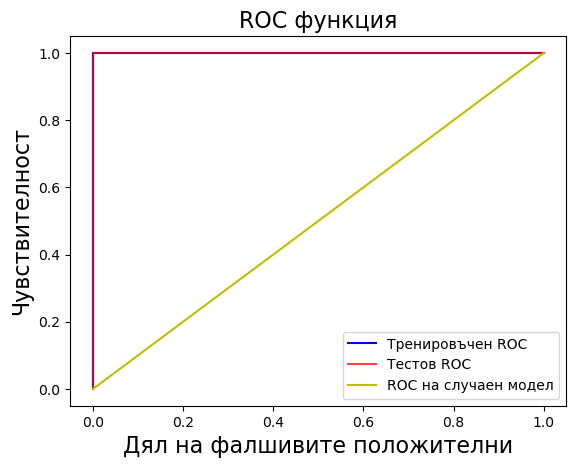

In [81]:
xgbc_cep_1730_7, feat_importances = train_test_validate_model(X, y, overall_df.columns[:-1])

In [82]:
feat_importances

,0,1
0,0.0,slice_id
1,0.0,start_s
2,0.0,end_s
3,0.0,duration_s
4,1.0,dom_quef_ms_mean
5,0.0,dom_quef_ms_std
6,0.0,dom_freq_hz_mean
7,0.0,dom_freq_hz_std
8,0.0,cpp_db_mean
9,0.0,cpp_db_std


F1: 1.000
Accuracy: 1.000
Precision: 1.000
ROC AUC: 1.000
Recall: 1.000


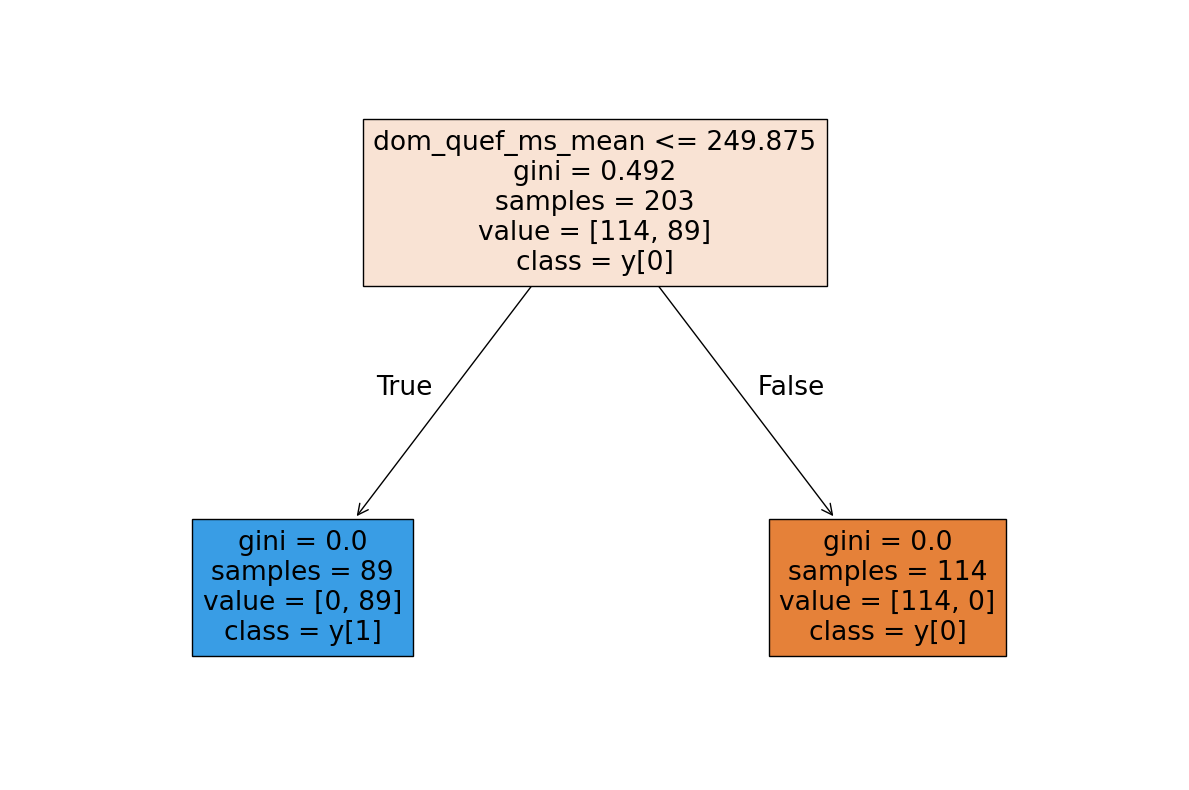

In [83]:
train_and_display_dtc(X, y, 'dom_quef_ms_mean')

In [24]:
feat_importances[feat_importances[0]==1][1].values[0]

'dom_quef_ms_mean'

Text(0.5, 1.0, 'Доминантна характеристика/Повреда')

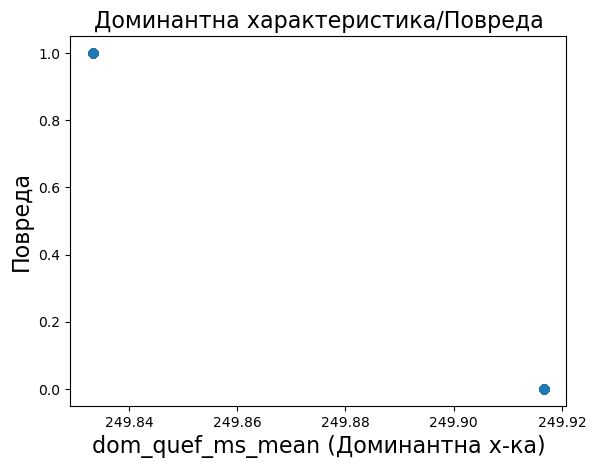

In [89]:
plt.scatter(overall_df['dom_quef_ms_mean'], overall_df['fault'])
plt.xlabel('dom_quef_ms_mean (Доминантна х-ка)', fontsize = 16)
plt.ylabel('Повреда', fontsize = 16)
plt.title('Доминантна характеристика/Повреда', fontsize=16)

## 1730 RPM; fault end 1; fs 12000; fault element 1; fault diameter 21

(485643,)
(365828,)
F1: 1.000
Accuracy: 1.000
Precision: 1.000
ROC AUC: 1.000
Recall: 1.000
F1: 1.000
Accuracy: 1.000
Precision: 1.000
ROC AUC: 1.000
Recall: 1.000


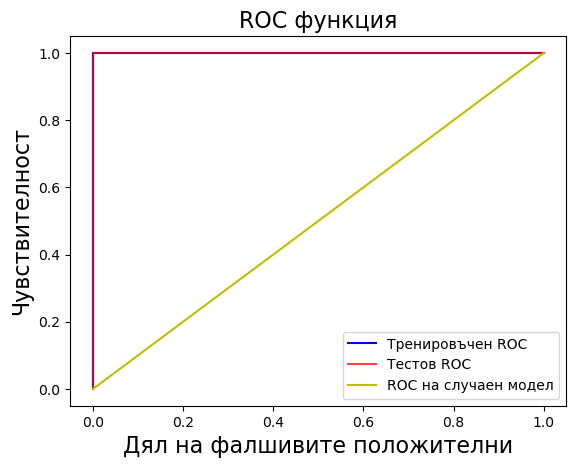

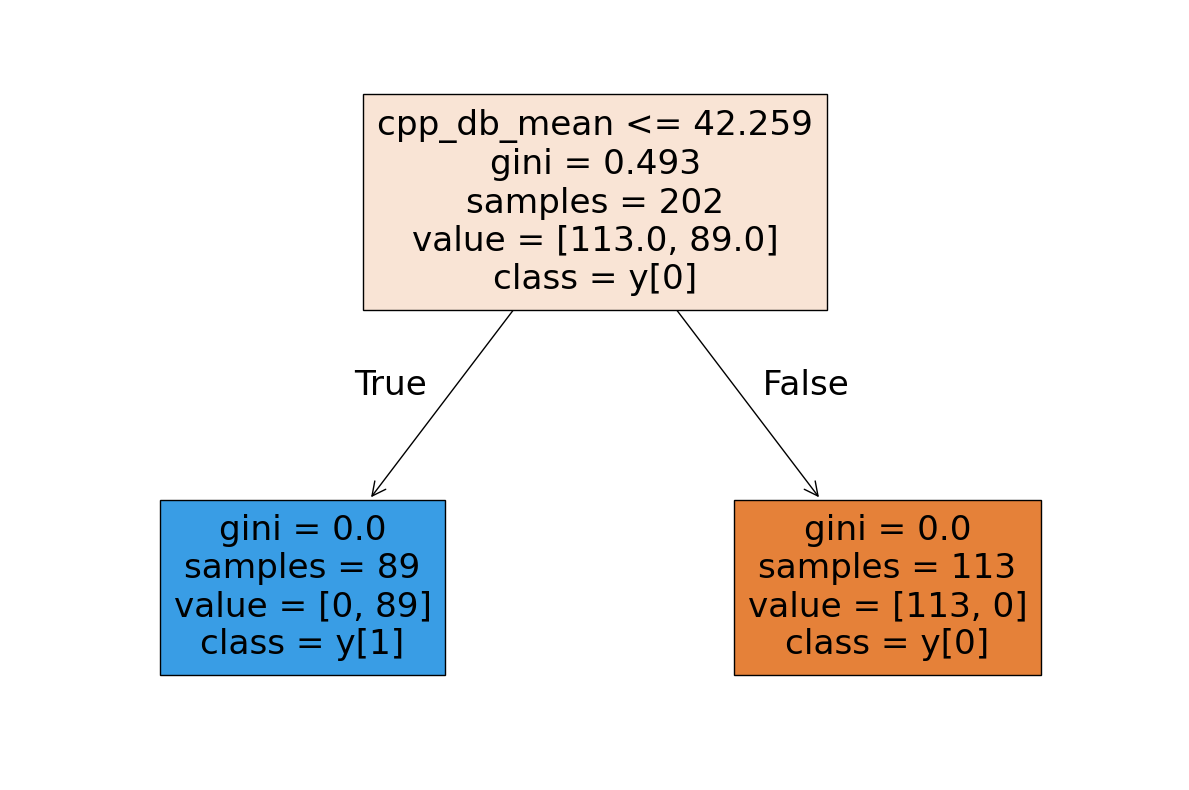

In [25]:
de_healthy = df[(df['fault_end'] == 0) & (df['samples_per_second'] == 12000) & (df['fault_element'] == 0) & (df['fault_diameter'] == 0)]['DE']
de_faulty = df[(df['fault_end'] == 1) & (df['samples_per_second'] == 12000) & (df['fault_element'] == 1) & (df['fault_diameter'] == 21)]['DE']

print(de_healthy.shape)
print(de_faulty.shape)

df_fe_healthy = extract_features(de_healthy, 12000, 0,
                                 return_per_frame=False)

df_fe_faulty = extract_features(de_faulty, 12000, 1,
                                 return_per_frame=False)

overall_df = pd.concat((df_fe_healthy, df_fe_faulty))

overall_df = overall_df.sample(frac=1)
X = overall_df.iloc[:, :-1]
y = overall_df.iloc[:, -1]

xgbc_cep_1730_7, feat_importances = train_test_validate_model(X, y, overall_df.columns[:-1])
dom_feat = feat_importances[feat_importances[0]==1][1].values[0]
train_and_display_dtc(X, y, dom_feat)

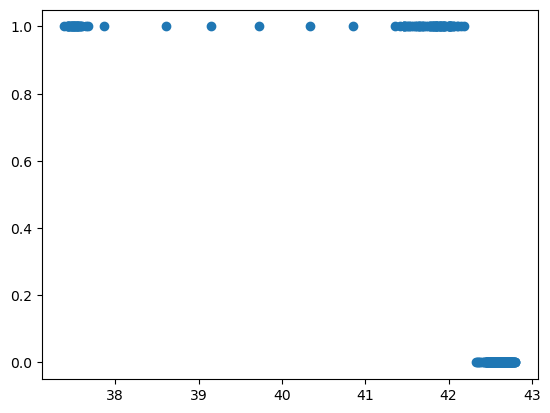

In [28]:
plt.scatter(overall_df['cpp_db_mean'], overall_df['fault'])

## 1797 RPM; fault end 1; fs 12000; fault element 1; fault diameter 7

In [ ]:
df_1797 = pd.read_csv(r"D:\Repositories\PhD\parsed_data\EE_data\1797_case_edu.csv")
df_1797

,DE,FE,fault_diameter,horse_power,rounds_per_minute,fault_end,samples_per_second,fault_element,fault
0,0.014603,0.192922,0,3,1730,0,12000,0,0
1,0.054449,0.164364,0,3,1730,0,12000,0,0
2,0.107646,0.090811,0,3,1730,0,12000,0,0
3,0.133722,0.086496,0,3,1730,0,12000,0,0
4,0.112652,0.099235,0,3,1730,0,12000,0,0
...,...,...,...,...,...,...,...,...,...
3528365,0.091857,0.155118,21,3,1730,2,48000,1,1
3528366,0.028101,-0.093087,21,3,1730,2,48000,1,1
3528367,-0.061238,-0.144956,21,3,1730,2,48000,1,1
3528368,0.079918,0.077803,21,3,1730,2,48000,1,1


(485643,)
(366988,)
F1: 1.000
Accuracy: 1.000
Precision: 1.000
ROC AUC: 1.000
Recall: 1.000
F1: 1.000
Accuracy: 1.000
Precision: 1.000
ROC AUC: 1.000
Recall: 1.000


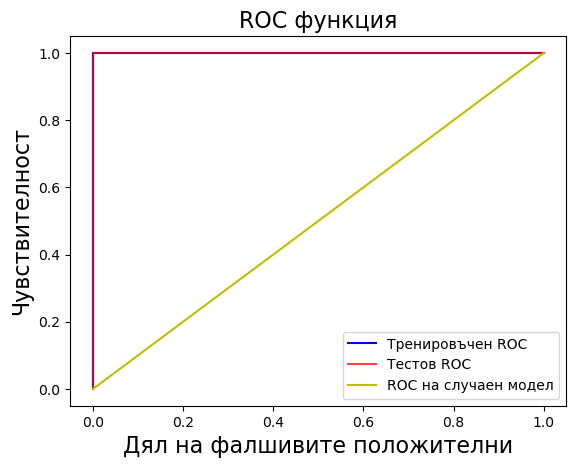

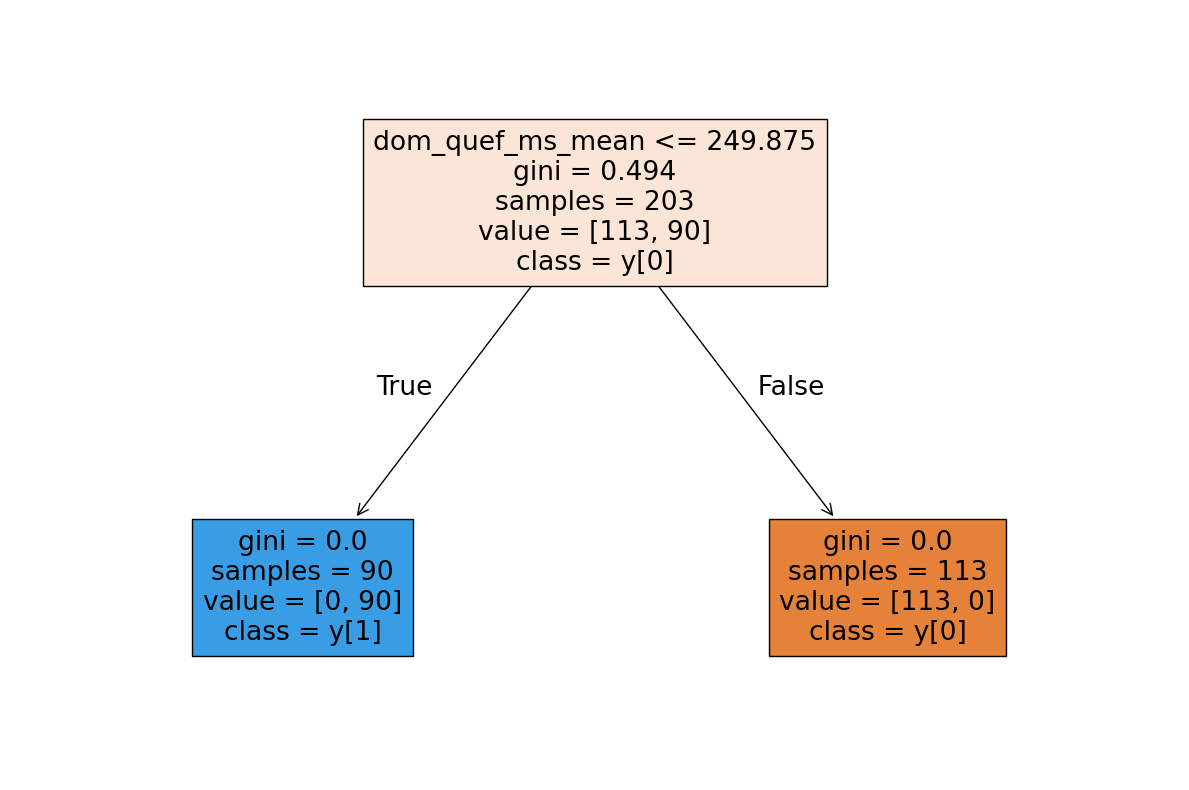

In [30]:
de_healthy = df_1797[(df_1797['fault_end'] == 0) & (df_1797['samples_per_second'] == 12000) & (df_1797['fault_element'] == 0) & (df_1797['fault_diameter'] == 0)]['DE']
de_faulty = df_1797[(df_1797['fault_end'] == 1) & (df_1797['samples_per_second'] == 12000) & (df_1797['fault_element'] == 1) & (df_1797['fault_diameter'] == 7)]['DE']

print(de_healthy.shape)
print(de_faulty.shape)

df_fe_healthy = extract_features(de_healthy, 12000, 0,
                                 return_per_frame=False)

df_fe_faulty = extract_features(de_faulty, 12000, 1,
                                 return_per_frame=False)

overall_df = pd.concat((df_fe_healthy, df_fe_faulty))

overall_df = overall_df.sample(frac=1)
X = overall_df.iloc[:, :-1]
y = overall_df.iloc[:, -1]

xgbc_cep_1730_7, feat_importances = train_test_validate_model(X, y, overall_df.columns[:-1])
dom_feat = feat_importances[feat_importances[0]==1][1].values[0]
train_and_display_dtc(X, y, dom_feat)

## 1797 RPM; fault end 1; fs 12000; fault element 1; fault diameter 21

(485643,)
(365828,)
F1: 1.000
Accuracy: 1.000
Precision: 1.000
ROC AUC: 1.000
Recall: 1.000
F1: 1.000
Accuracy: 1.000
Precision: 1.000
ROC AUC: 1.000
Recall: 1.000


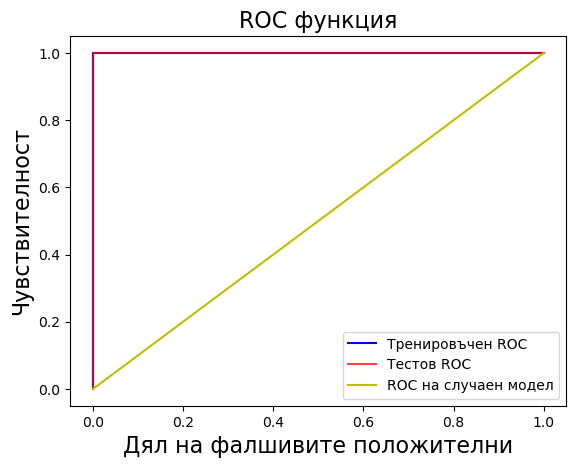

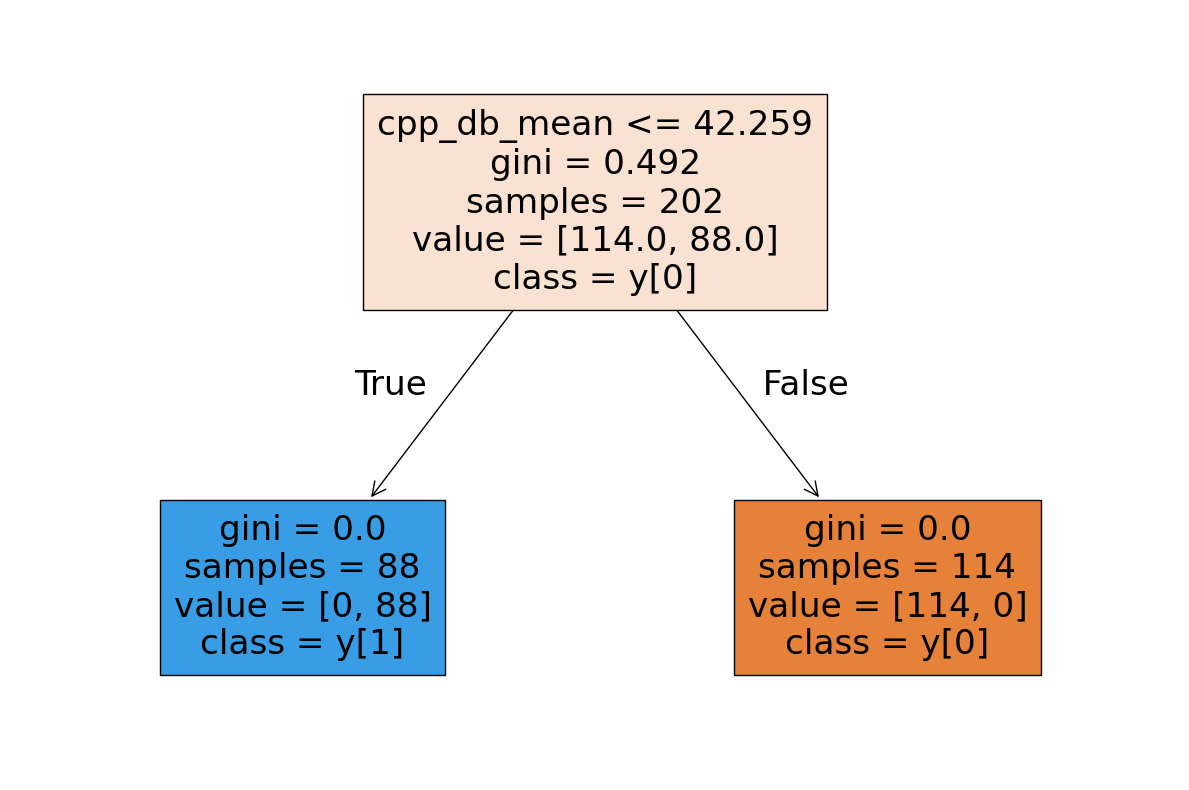

In [31]:
de_healthy = df_1797[(df_1797['fault_end'] == 0) & (df_1797['samples_per_second'] == 12000) & (df_1797['fault_element'] == 0) & (df_1797['fault_diameter'] == 0)]['DE']
de_faulty = df_1797[(df_1797['fault_end'] == 1) & (df_1797['samples_per_second'] == 12000) & (df_1797['fault_element'] == 1) & (df_1797['fault_diameter'] == 21)]['DE']

print(de_healthy.shape)
print(de_faulty.shape)

df_fe_healthy = extract_features(de_healthy, 12000, 0,
                                 return_per_frame=False)

df_fe_faulty = extract_features(de_faulty, 12000, 1,
                                 return_per_frame=False)

overall_df = pd.concat((df_fe_healthy, df_fe_faulty))

overall_df = overall_df.sample(frac=1)
X = overall_df.iloc[:, :-1]
y = overall_df.iloc[:, -1]

xgbc_cep_1730_7, feat_importances = train_test_validate_model(X, y, overall_df.columns[:-1])
dom_feat = feat_importances[feat_importances[0]==1][1].values[0]
train_and_display_dtc(X, y, dom_feat)

# ICE

In [32]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler

def process_ice_signal(signal):
    qt = QuantileTransformer(output_distribution='normal')
    sds = StandardScaler()
    return sds.fit_transform(qt.fit_transform(signal.values.reshape(-1, 1))).flatten()

In [33]:
df_ice = pd.read_csv(r"D:\Repositories\PhD\parsed_data\ICE_data\internal_combustion_engine_bearings_fixed_duplicates.csv")
df_ice

,Time,Demand 1,Control 1,Output Drive 1,Channel 1,Channel 2,Channel 3,Channel 4,Channel 1 Kurtosis,Channel 2 Kurtosis,...,Rear Input 5,Rear Input 6,Rear Input 7,Rear Input 8,FAULT,RPM,HUMIDITY%,TEMPERATURE_Celsius,resultant_vibration_magnitude,resultant_vibration_magnitude_normal_dist
0,0.001450,0.125011,0.176033,0.000000,0.211458,0.209182,0.145823,1.624200e-15,2.52457,2.94874,...,0,0,0,0,1,1000,0,-10,0.331264,-1.104839
1,0.006283,0.125011,0.176033,0.000012,0.206329,0.206513,0.150478,1.643320e-15,2.32290,2.46553,...,0,0,0,0,1,1000,0,-10,0.328425,-1.113447
2,0.009633,0.125011,0.172626,0.000013,0.206351,0.194663,0.148313,1.528270e-15,2.26458,2.55488,...,0,0,0,0,1,1000,0,-10,0.320111,-1.139087
3,0.013200,0.125011,0.172626,0.000014,0.214463,0.214489,0.155652,1.791370e-15,2.53380,2.66379,...,0,0,0,0,1,1000,0,-10,0.340921,-1.076103
4,0.016583,0.125011,0.172626,0.000015,0.210449,0.198857,0.154162,1.594310e-15,2.51443,2.81510,...,0,0,0,0,1,1000,0,-10,0.328023,-1.114673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390057,27.302300,0.500044,0.515140,0.043543,0.554265,0.560519,1.633510,1.712510e-15,3.10602,3.09644,...,0,0,0,0,0,2000,50,45,1.813766,0.595405
390058,27.305700,0.500044,0.515140,0.043541,0.554672,0.560996,1.646360,1.711110e-15,3.10423,3.09293,...,0,0,0,0,0,2000,50,45,1.825617,0.601918
390059,27.309200,0.500044,0.515140,0.043536,0.555249,0.561109,1.645410,1.710140e-15,3.11372,3.09118,...,0,0,0,0,0,2000,50,45,1.824971,0.601564
390060,27.312500,0.500044,0.515305,0.043532,0.555029,0.560672,1.640060,1.711640e-15,3.11269,3.09097,...,0,0,0,0,0,2000,50,45,1.819947,0.598807


## 1000 RPM; 50% Humidity; 30 C Temp

In [90]:
c1_healthy = process_ice_signal(df_ice[(df_ice['RPM'] == 1000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 0)]['Channel 1'])
c1_faulty = process_ice_signal(df_ice[(df_ice['RPM'] == 1000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 1)]['Channel 1'])
c2_healthy = process_ice_signal(df_ice[(df_ice['RPM'] == 1000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 0)]['Channel 2'])
c2_faulty = process_ice_signal(df_ice[(df_ice['RPM'] == 1000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 1)]['Channel 2'])
c3_healthy = process_ice_signal(df_ice[(df_ice['RPM'] == 1000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 0)]['Channel 3'])
c3_faulty = process_ice_signal(df_ice[(df_ice['RPM'] == 1000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 1)]['Channel 3'])

print(c1_healthy.shape)
print(c1_faulty.shape)

print(c2_healthy.shape)
print(c2_faulty.shape)

print(c3_healthy.shape)
print(c3_faulty.shape)

(5264,)
(4535,)
(5264,)
(4535,)
(5264,)
(4535,)


In [91]:
c1_feats = extract_features(c1_healthy, 3200, 0, slice_len_s = 0.05, hop_s = 0.025, frame_len_s=0.25)
c1_feats.columns = c1_feats.columns + '_c1'
c2_feats = extract_features(c2_healthy, 3200, 0, slice_len_s=0.05, hop_s = 0.025)
c2_feats.columns = c2_feats.columns + '_c2'
c3_feats = extract_features(c3_healthy, 3200, 0, slice_len_s=0.05, hop_s = 0.025)
c3_feats.columns = c3_feats.columns + '_c3'
df_healthy = pd.concat((c1_feats, c2_feats, c3_feats), axis = 1)
df_healthy

,slice_id_c1,start_s_c1,end_s_c1,duration_s_c1,dom_quef_ms_mean_c1,dom_quef_ms_std_c1,dom_freq_hz_mean_c1,dom_freq_hz_std_c1,cpp_db_mean_c1,cpp_db_std_c1,...,cceps_mean_15_c3,cceps_mean_16_c3,cceps_mean_17_c3,cceps_mean_18_c3,cceps_mean_19_c3,cceps_mean_20_c3,cceps_mean_21_c3,cceps_mean_22_c3,cceps_mean_23_c3,fault_c3
0,0,0.000,0.050,0.05,249.6875,0.0,4.005006,0.0,41.356302,0.0,...,0.000480,0.055012,0.036588,0.013535,0.023224,0.026650,0.019690,0.026132,0.016226,0
1,1,0.025,0.075,0.05,0.3125,0.0,3200.000000,0.0,76.787478,0.0,...,0.027118,0.010182,-0.015662,0.028059,0.073099,-0.015236,-0.007251,0.011176,0.016484,0
2,2,0.050,0.100,0.05,0.3125,0.0,3200.000000,0.0,72.486920,0.0,...,0.020888,0.025065,0.027824,0.030959,0.018046,0.031431,0.014678,0.011049,0.017043,0
3,3,0.075,0.125,0.05,0.3125,0.0,3200.000000,0.0,71.451748,0.0,...,0.018365,-0.005174,0.019586,-0.007053,0.066950,0.007218,-0.023060,0.002620,0.042478,0
4,4,0.100,0.150,0.05,0.3125,0.0,3200.000000,0.0,72.147480,0.0,...,0.028854,0.025922,0.028992,0.027760,0.023037,0.017030,0.025236,0.004942,0.027427,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,60,1.500,1.550,0.05,0.3125,0.0,3200.000000,0.0,37.742195,0.0,...,0.038923,-0.007501,0.011376,0.035141,0.039419,-0.041489,0.039541,0.058831,0.027058,0
61,61,1.525,1.575,0.05,0.3125,0.0,3200.000000,0.0,42.756100,0.0,...,0.062114,0.061447,0.081570,0.074634,-0.041820,-0.052140,-0.097023,-0.072610,-0.016644,0
62,62,1.550,1.600,0.05,0.3125,0.0,3200.000000,0.0,46.521845,0.0,...,0.023811,-0.023299,0.010352,0.033421,0.029729,0.019544,-0.022494,0.027647,0.012126,0
63,63,1.575,1.625,0.05,0.3125,0.0,3200.000000,0.0,36.008097,0.0,...,0.213703,-0.263684,-0.026787,0.024382,0.040483,0.020333,0.008519,0.080175,-0.034677,0


In [92]:
c1_feats = extract_features(c1_faulty, 3200, 1,slice_len_s = 0.05,hop_s = 0.025)
c1_feats.columns = c1_feats.columns + '_c1'
c2_feats = extract_features(c2_faulty, 3200, 1, slice_len_s=0.05, hop_s = 0.025)
c2_feats.columns = c2_feats.columns + '_c2'
c3_feats = extract_features(c3_faulty, 3200, 1, slice_len_s=0.05, hop_s = 0.025)
c3_feats.columns = c3_feats.columns + '_c3'
df_faulty = pd.concat((c1_feats, c2_feats, c3_feats), axis = 1)
df_faulty

,slice_id_c1,start_s_c1,end_s_c1,duration_s_c1,dom_quef_ms_mean_c1,dom_quef_ms_std_c1,dom_freq_hz_mean_c1,dom_freq_hz_std_c1,cpp_db_mean_c1,cpp_db_std_c1,...,cceps_mean_15_c3,cceps_mean_16_c3,cceps_mean_17_c3,cceps_mean_18_c3,cceps_mean_19_c3,cceps_mean_20_c3,cceps_mean_21_c3,cceps_mean_22_c3,cceps_mean_23_c3,fault_c3
0,0,0.000000,0.050000,0.05,0.3125,0.0,3200.000000,0.0,56.350646,0.0,...,0.036596,0.029716,0.022440,0.031656,0.020468,0.021876,0.012066,0.013542,0.013479,1
1,1,0.025000,0.075000,0.05,0.3125,0.0,3200.000000,0.0,82.104400,0.0,...,0.026106,0.024012,0.023243,0.020044,0.033106,0.026595,0.007645,0.018241,0.015449,1
2,2,0.050000,0.100000,0.05,249.6875,0.0,4.005006,0.0,58.107809,0.0,...,0.076141,0.026966,0.025147,-0.023588,0.005805,0.014775,0.033656,0.039820,0.008620,1
3,3,0.075000,0.125000,0.05,0.3125,0.0,3200.000000,0.0,42.076867,0.0,...,0.075186,-0.060367,0.027140,0.019338,0.029586,-0.009830,0.004950,-0.030765,0.021138,1
4,4,0.100000,0.150000,0.05,0.3125,0.0,3200.000000,0.0,35.743372,0.0,...,0.055077,-0.022895,0.045351,0.018428,-0.044579,-0.064143,-0.052755,0.066481,-0.065565,1
5,5,0.125000,0.175000,0.05,249.6875,0.0,4.005006,0.0,57.978084,0.0,...,0.011494,-0.000176,0.025393,-0.042729,-0.032614,0.001649,0.056217,-0.040000,0.020897,1
6,6,0.150000,0.200000,0.05,0.3125,0.0,3200.000000,0.0,80.655033,0.0,...,0.004130,0.073495,0.026036,0.026182,0.102639,0.105496,-0.069680,0.051460,0.066794,1
7,7,0.175000,0.225000,0.05,0.3125,0.0,3200.000000,0.0,79.330027,0.0,...,-0.006546,0.104217,0.029958,0.074792,0.018774,0.014493,-0.113410,0.003166,-0.052104,1
8,8,0.200000,0.250000,0.05,0.3125,0.0,3200.000000,0.0,78.381997,0.0,...,-0.023123,0.098354,-0.024898,0.035900,0.076596,0.038047,-0.011253,0.067217,0.000831,1
9,9,0.225000,0.275000,0.05,0.3125,0.0,3200.000000,0.0,70.312020,0.0,...,0.027836,0.086014,-0.025800,0.014032,-0.079916,0.058090,0.014356,0.012540,0.004081,1


In [93]:
overall_df = pd.concat((df_healthy, df_faulty)).sample(frac=1)

In [94]:
overall_df['fault'] = (overall_df['fault_c1'] & overall_df['fault_c2'] & overall_df['fault_c3'])
overall_df

,slice_id_c1,start_s_c1,end_s_c1,duration_s_c1,dom_quef_ms_mean_c1,dom_quef_ms_std_c1,dom_freq_hz_mean_c1,dom_freq_hz_std_c1,cpp_db_mean_c1,cpp_db_std_c1,...,cceps_mean_16_c3,cceps_mean_17_c3,cceps_mean_18_c3,cceps_mean_19_c3,cceps_mean_20_c3,cceps_mean_21_c3,cceps_mean_22_c3,cceps_mean_23_c3,fault_c3,fault
30,30,0.750,0.800,0.05,0.3125,0.0,3200.000000,0.0,42.884173,0.0,...,0.015620,0.023157,0.024672,0.019455,0.012641,0.007647,0.009941,0.020594,0,0
34,34,0.850,0.900,0.05,0.3125,0.0,3200.000000,0.0,42.153059,0.0,...,0.027091,0.039989,0.029017,0.092293,-0.138024,0.037214,0.061599,-0.054773,0,0
18,18,0.450,0.500,0.05,249.6875,0.0,4.005006,0.0,53.136575,0.0,...,0.038271,0.031817,0.053410,-0.014832,0.020626,0.011185,-0.033511,-0.013516,0,0
42,42,1.050,1.100,0.05,0.3125,0.0,3200.000000,0.0,43.925198,0.0,...,0.034483,-0.048188,-0.014579,0.031546,0.069624,-0.000412,0.027110,-0.012843,0,0
4,4,0.100,0.150,0.05,0.3125,0.0,3200.000000,0.0,35.743372,0.0,...,-0.022895,0.045351,0.018428,-0.044579,-0.064143,-0.052755,0.066481,-0.065565,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,6,0.150,0.200,0.05,0.3125,0.0,3200.000000,0.0,80.655033,0.0,...,0.073495,0.026036,0.026182,0.102639,0.105496,-0.069680,0.051460,0.066794,1,1
23,23,0.575,0.625,0.05,0.3125,0.0,3200.000000,0.0,46.380299,0.0,...,0.053608,-0.010664,0.036931,-0.004584,0.017338,-0.024682,-0.038637,0.025919,1,1
54,54,1.350,1.400,0.05,0.3125,0.0,3200.000000,0.0,37.813834,0.0,...,0.072034,-0.009058,-0.045504,-0.007226,0.049551,0.061225,0.019775,0.048421,0,0
27,27,0.675,0.725,0.05,249.6875,0.0,4.005006,0.0,43.294722,0.0,...,-0.003850,0.034931,0.047976,0.013885,0.049107,0.059900,0.051656,-0.018359,0,0


In [95]:
X = overall_df.drop(['slice_id_c1', 'slice_id_c2', 'slice_id_c3',
                     'start_s_c1', 'start_s_c2', 'start_s_c3',
                     'end_s_c1', 'end_s_c2','end_s_c3',
                     'duration_s_c1', 'duration_s_c2', 'duration_s_c3',
                     'fault_c1', 'fault_c2', 'fault_c3', 'fault'], axis = 1)
y = overall_df['fault']

F1: 0.737
Accuracy: 0.839
Precision: 0.875
ROC AUC: 0.793
Recall: 0.636


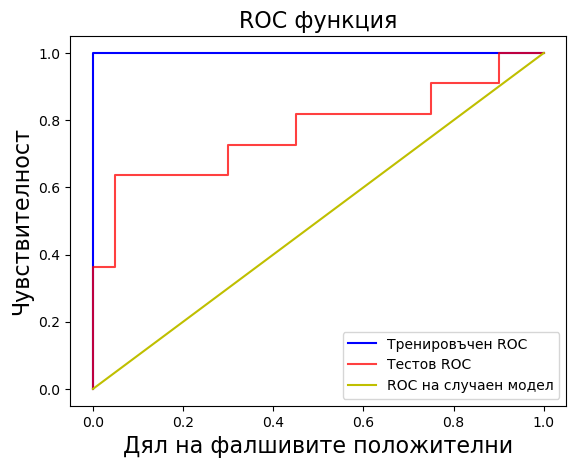

In [96]:
xgbc_cep_ice_1000, feat_importances = train_test_validate_model(X, y, feat_names = overall_df.drop(['slice_id_c1', 'slice_id_c2', 'slice_id_c3',
                     'start_s_c1', 'start_s_c2', 'start_s_c3',
                     'end_s_c1', 'end_s_c2','end_s_c3',
                     'duration_s_c1', 'duration_s_c2', 'duration_s_c3',
                     'fault_c1', 'fault_c2', 'fault_c3', 'fault'], axis = 1).columns)

In [97]:
feat_importances[feat_importances[0] != 0].sort_values(0, ascending=False)

,0,1
36,0.158159,cpp_db_mean_c2
40,0.087616,cceps_mean_0_c2
38,0.070010,low_q_energy_db_mean_c2
4,0.068820,cpp_db_mean_c1
79,0.051278,cceps_mean_7_c3
8,0.044700,cceps_mean_0_c1
84,0.044338,cceps_mean_12_c3
72,0.041733,cceps_mean_0_c3
45,0.040702,cceps_mean_5_c2
15,0.033492,cceps_mean_7_c1


F1: 1.000
Accuracy: 1.000
Precision: 1.000
ROC AUC: 1.000
Recall: 1.000
F1: 0.545
Accuracy: 0.677
Precision: 0.545
ROC AUC: 0.648
Recall: 0.545


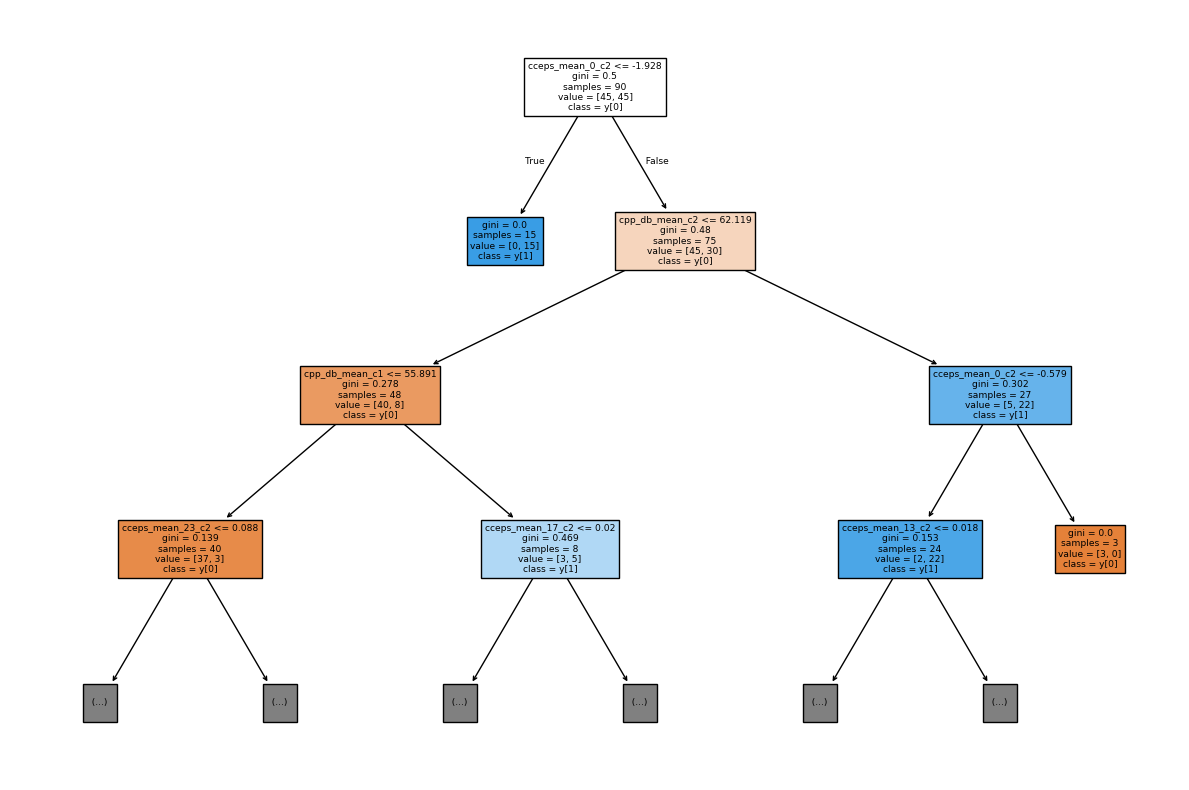

In [98]:
train_and_display_dtc(X, y, train_metrices=True)

## 1500 RPM; 50% Humidity; 30 C Temp

(1513,)
(1778,)
(1513,)
(1778,)
(1513,)
(1778,)
F1: 0.615
Accuracy: 0.500
Precision: 0.444
ROC AUC: 0.583
Recall: 1.000
F1: 1.000
Accuracy: 1.000
Precision: 1.000
ROC AUC: 1.000
Recall: 1.000
F1: 0.364
Accuracy: 0.300
Precision: 0.286
ROC AUC: 0.333
Recall: 0.500


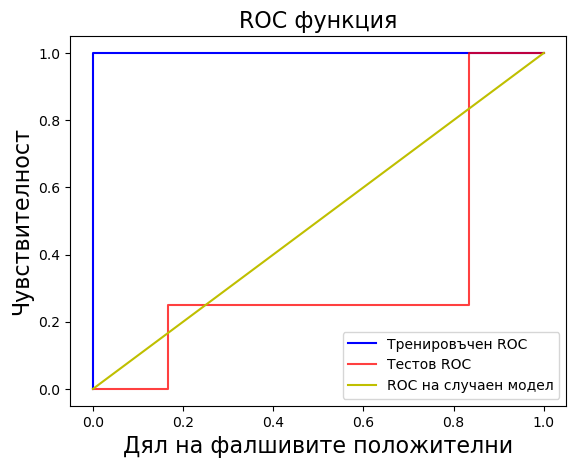

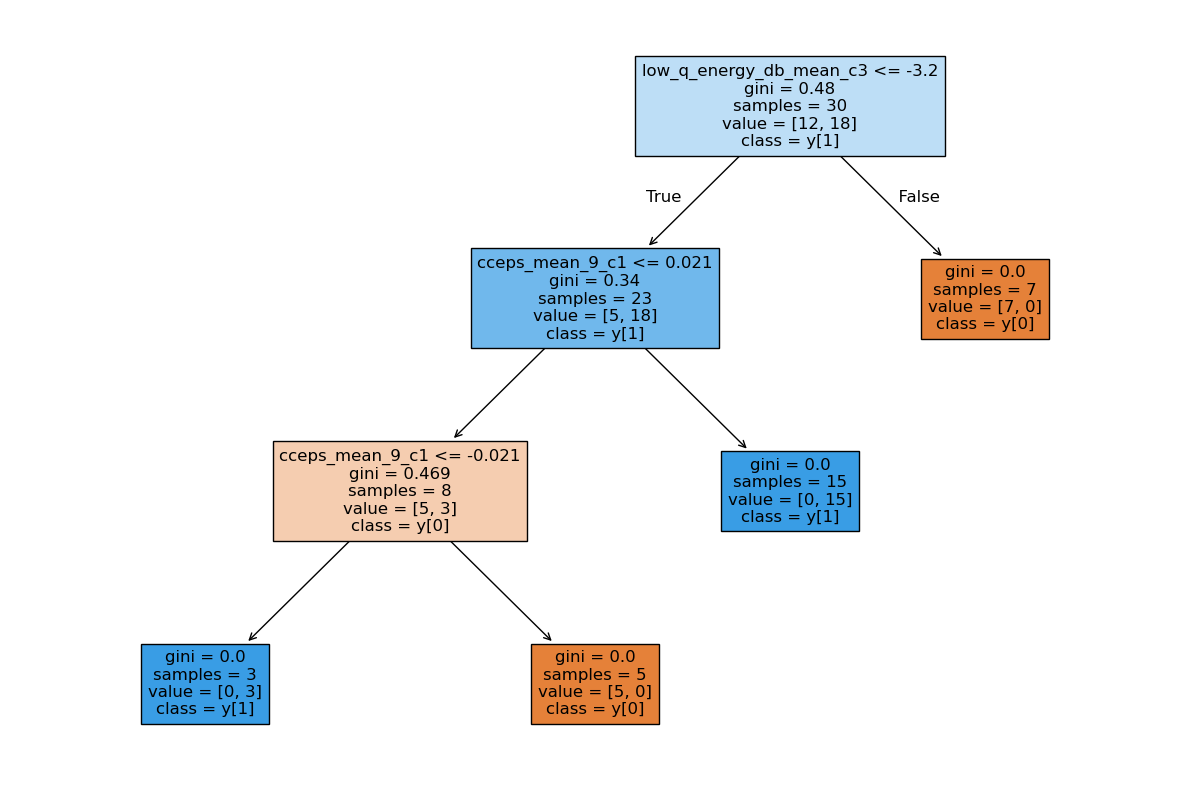

In [100]:
c1_healthy = process_ice_signal(df_ice[(df_ice['RPM'] == 1500) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 0)]['Channel 1'])
c1_faulty = process_ice_signal(df_ice[(df_ice['RPM'] == 1500) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 1)]['Channel 1'])
c2_healthy = process_ice_signal(df_ice[(df_ice['RPM'] == 1500) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 0)]['Channel 2'])
c2_faulty = process_ice_signal(df_ice[(df_ice['RPM'] == 1500) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 1)]['Channel 2'])
c3_healthy = process_ice_signal(df_ice[(df_ice['RPM'] == 1500) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 0)]['Channel 3'])
c3_faulty = process_ice_signal(df_ice[(df_ice['RPM'] == 1500) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 1)]['Channel 3'])

print(c1_healthy.shape)
print(c1_faulty.shape)

print(c2_healthy.shape)
print(c2_faulty.shape)

print(c3_healthy.shape)
print(c3_faulty.shape)

c1_feats = extract_features(c1_healthy, 3200, 0, slice_len_s = 0.05, hop_s = 0.025, frame_len_s=0.25)
c1_feats.columns = c1_feats.columns + '_c1'
c2_feats = extract_features(c2_healthy, 3200, 0, slice_len_s=0.05, hop_s = 0.025)
c2_feats.columns = c2_feats.columns + '_c2'
c3_feats = extract_features(c3_healthy, 3200, 0, slice_len_s=0.05, hop_s = 0.025)
c3_feats.columns = c3_feats.columns + '_c3'
df_healthy = pd.concat((c1_feats, c2_feats, c3_feats), axis = 1)

c1_feats = extract_features(c1_faulty, 3200, 1,slice_len_s = 0.05,hop_s = 0.025)
c1_feats.columns = c1_feats.columns + '_c1'
c2_feats = extract_features(c2_faulty, 3200, 1, slice_len_s=0.05, hop_s = 0.025)
c2_feats.columns = c2_feats.columns + '_c2'
c3_feats = extract_features(c3_faulty, 3200, 1, slice_len_s=0.05, hop_s = 0.025)
c3_feats.columns = c3_feats.columns + '_c3'
df_faulty = pd.concat((c1_feats, c2_feats, c3_feats), axis = 1)

overall_df = pd.concat((df_healthy, df_faulty)).sample(frac=1)
overall_df['fault'] = (overall_df['fault_c1'] & overall_df['fault_c2'] & overall_df['fault_c3'])

X = overall_df.drop(['slice_id_c1', 'slice_id_c2', 'slice_id_c3',
                     'start_s_c1', 'start_s_c2', 'start_s_c3',
                     'end_s_c1', 'end_s_c2','end_s_c3',
                     'duration_s_c1', 'duration_s_c2', 'duration_s_c3',
                     'fault_c1', 'fault_c2', 'fault_c3', 'fault'], axis = 1)
y = overall_df['fault']

xgbc_cep_ice_1500, feat_importances = train_test_validate_model(X, y, feat_names = overall_df.drop(['slice_id_c1', 'slice_id_c2', 'slice_id_c3',
                     'start_s_c1', 'start_s_c2', 'start_s_c3',
                     'end_s_c1', 'end_s_c2','end_s_c3',
                     'duration_s_c1', 'duration_s_c2', 'duration_s_c3',
                     'fault_c1', 'fault_c2', 'fault_c3', 'fault'], axis = 1).columns)
train_and_display_dtc(X, y, train_metrices=True)

## 2000 RPM; 50% Humidity; 30 C Temp

(8276,)
(3615,)
(8276,)
(3615,)
(8276,)
(3615,)
F1: 0.649
Accuracy: 0.649
Precision: 0.500
ROC AUC: 0.712
Recall: 0.923
F1: 1.000
Accuracy: 1.000
Precision: 1.000
ROC AUC: 1.000
Recall: 1.000
F1: 0.480
Accuracy: 0.649
Precision: 0.500
ROC AUC: 0.606
Recall: 0.462


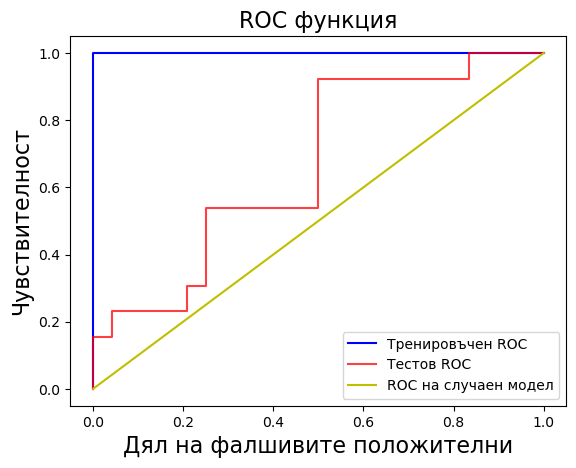

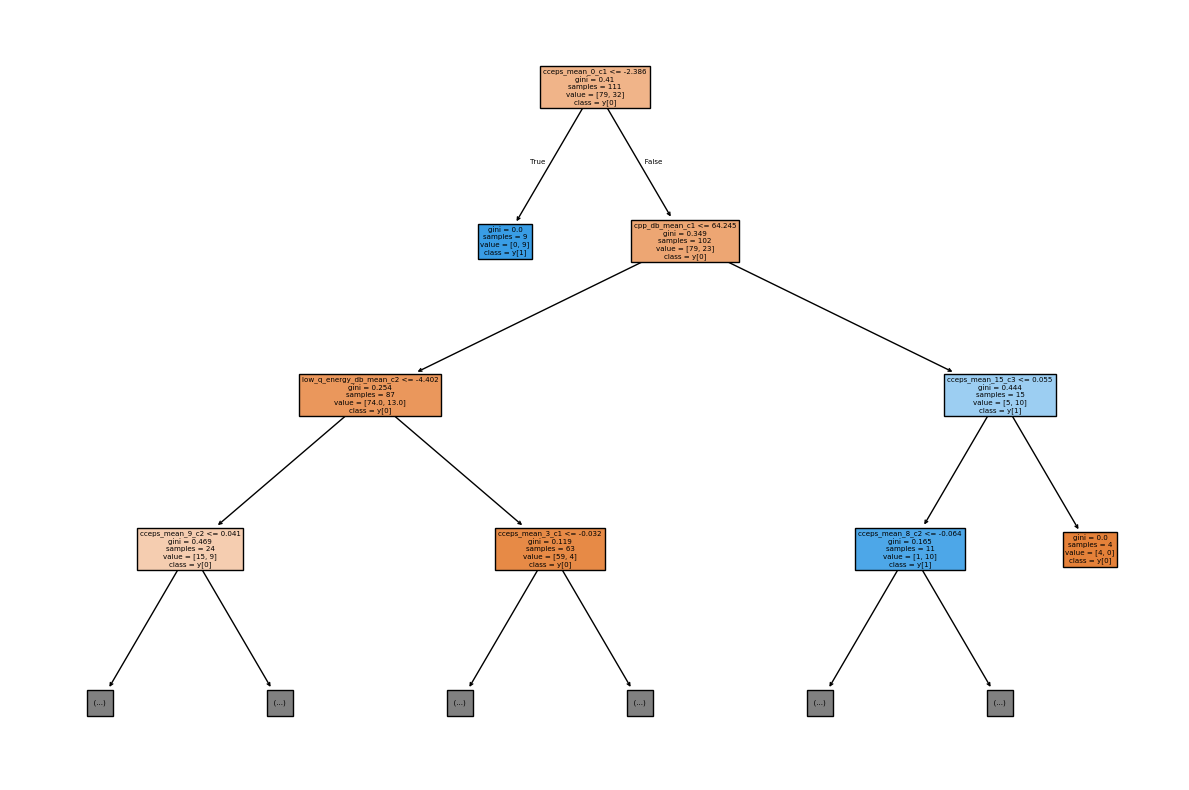

In [99]:
c1_healthy = process_ice_signal(df_ice[(df_ice['RPM'] == 2000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 0)]['Channel 1'])
c1_faulty = process_ice_signal(df_ice[(df_ice['RPM'] == 2000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 1)]['Channel 1'])
c2_healthy = process_ice_signal(df_ice[(df_ice['RPM'] == 2000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 0)]['Channel 2'])
c2_faulty = process_ice_signal(df_ice[(df_ice['RPM'] == 2000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 1)]['Channel 2'])
c3_healthy = process_ice_signal(df_ice[(df_ice['RPM'] == 2000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 0)]['Channel 3'])
c3_faulty = process_ice_signal(df_ice[(df_ice['RPM'] == 2000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 1)]['Channel 3'])

print(c1_healthy.shape)
print(c1_faulty.shape)

print(c2_healthy.shape)
print(c2_faulty.shape)

print(c3_healthy.shape)
print(c3_faulty.shape)

c1_feats = extract_features(c1_healthy, 3200, 0, slice_len_s = 0.05, hop_s = 0.025, frame_len_s=0.25)
c1_feats.columns = c1_feats.columns + '_c1'
c2_feats = extract_features(c2_healthy, 3200, 0, slice_len_s=0.05, hop_s = 0.025)
c2_feats.columns = c2_feats.columns + '_c2'
c3_feats = extract_features(c3_healthy, 3200, 0, slice_len_s=0.05, hop_s = 0.025)
c3_feats.columns = c3_feats.columns + '_c3'
df_healthy = pd.concat((c1_feats, c2_feats, c3_feats), axis = 1)

c1_feats = extract_features(c1_faulty, 3200, 1,slice_len_s = 0.05,hop_s = 0.025)
c1_feats.columns = c1_feats.columns + '_c1'
c2_feats = extract_features(c2_faulty, 3200, 1, slice_len_s=0.05, hop_s = 0.025)
c2_feats.columns = c2_feats.columns + '_c2'
c3_feats = extract_features(c3_faulty, 3200, 1, slice_len_s=0.05, hop_s = 0.025)
c3_feats.columns = c3_feats.columns + '_c3'
df_faulty = pd.concat((c1_feats, c2_feats, c3_feats), axis = 1)

overall_df = pd.concat((df_healthy, df_faulty)).sample(frac=1)
overall_df['fault'] = (overall_df['fault_c1'] & overall_df['fault_c2'] & overall_df['fault_c3'])

X = overall_df.drop(['slice_id_c1', 'slice_id_c2', 'slice_id_c3',
                     'start_s_c1', 'start_s_c2', 'start_s_c3',
                     'end_s_c1', 'end_s_c2','end_s_c3',
                     'duration_s_c1', 'duration_s_c2', 'duration_s_c3',
                     'fault_c1', 'fault_c2', 'fault_c3', 'fault'], axis = 1)
y = overall_df['fault']

xgbc_cep_ice_1500, feat_importances = train_test_validate_model(X, y, feat_names = overall_df.drop(['slice_id_c1', 'slice_id_c2', 'slice_id_c3',
                     'start_s_c1', 'start_s_c2', 'start_s_c3',
                     'end_s_c1', 'end_s_c2','end_s_c3',
                     'duration_s_c1', 'duration_s_c2', 'duration_s_c3',
                     'fault_c1', 'fault_c2', 'fault_c3', 'fault'], axis = 1).columns)
train_and_display_dtc(X, y, train_metrices=True)